In [1]:
import pandas as pd
import numpy as np
import ast
from itertools import combinations

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

from scipy.stats import mannwhitneyu
from scipy.stats import wilcoxon

import statsmodels.formula.api as smf
from statsmodels.tools.sm_exceptions import ConvergenceWarning
import warnings


# Loading Raw Data

In [2]:
ia_Q_path = "full/ia_Q.csv"
ia_A_path = "full/ia_A.csv"
ia_QA_path = "full/ia_QA.csv"

In [3]:
#df_Q = pd.read_csv(ia_Q_path)
df_A = pd.read_csv(ia_A_path)
#df_QA = pd.read_csv(ia_QA_path)

# Selecting Relevant and Separating Reading Regimes

In [4]:
df_A_filtered = df_A[(df_A['repeated_reading_trial'] == False) & ((df_A['practice_trial'] == False))]

df_A_hunters = df_A_filtered[df_A_filtered['question_preview'] == True]
df_A_gatherers = df_A_filtered[df_A_filtered['question_preview'] == False]

# Generating Basic By Row Features

In [5]:
def create_area_label(df):
    for col in ['question', 'answer_1', 'answer_2', 'answer_3', 'answer_4']:
        df[col] = df[col].fillna('').astype(str)

    df['question_tokens'] = df['question'].str.split()
    df['a_tokens'] = df['answer_1'].str.split()
    df['b_tokens'] = df['answer_2'].str.split()
    df['c_tokens'] = df['answer_3'].str.split()
    df['d_tokens'] = df['answer_4'].str.split()

    df['question_len'] = df['question_tokens'].apply(len)
    df['a_len'] = df['a_tokens'].apply(len)
    df['b_len'] = df['b_tokens'].apply(len)
    df['c_len'] = df['c_tokens'].apply(len)
    df['d_len'] = df['d_tokens'].apply(len)

    def assign_area(group):
        q_len = group['question_len'].iloc[0]
        a_len = group['a_len'].iloc[0]
        b_len = group['b_len'].iloc[0]
        c_len = group['c_len'].iloc[0]
        d_len = group['d_len'].iloc[0]

        q_end = q_len - 1
        a_end = q_len + a_len - 1
        b_end = q_len + a_len + b_len - 1
        c_end = q_len + a_len + b_len + c_len - 1
        d_end = q_len + a_len + b_len + c_len + d_len

        index_id = group['IA_ID'] - 1

        conditions = [
            (index_id <= q_end),
            (index_id > q_end) & (index_id <= a_end),
            (index_id > a_end) & (index_id <= b_end),
            (index_id > b_end) & (index_id <= c_end),
            (index_id > c_end) & (index_id <= d_end)
        ]

        choices = ['question', 'answer_A', 'answer_B', 'answer_C', 'answer_D']
        group['area_label'] = np.select(conditions, choices, default='unknown')
        return group

    df_area_split = df.set_index(['TRIAL_INDEX', 'participant_id']).groupby(['TRIAL_INDEX', 'participant_id'], group_keys=False).apply(assign_area)
    return df_area_split

In [6]:
def create_correct_answer(df):
    df = df.copy()
    df['is_correct'] = (df['selected_answer_position'] == df['correct_answer_position']).astype(int)
    return df

In [7]:
def create_area_screen_loc(df):
    def get_screen_loc(row):
        if row['area_label'] == 'question':
            return -1
        elif row['area_label'].startswith('answer_'):
            answers_order = ast.literal_eval(row['answers_order'])
            answer_letter = row['area_label'][-1]
            return answers_order.index(answer_letter)
        return None

    df['area_screen_loc'] = df.apply(get_screen_loc, axis=1)
    return df

In [8]:
def create_selected_answer_label(df):
    df = df.copy()
    df['answers_order'] = df['answers_order'].apply(ast.literal_eval)
    df['selected_answer_label'] = df.apply(lambda row: row['answers_order'][row['selected_answer_position']], axis=1)
    return df

In [9]:
def created_selected_area_bool(df):
    area_mapping = {
    'A': 'answer_A',
    'B': 'answer_B',
    'C': 'answer_C',
    'D': 'answer_D'
    }

    df['selected_area'] = df['selected_answer_label'].map(area_mapping)
    df['is_selected_area'] = df['area_label'] == df['selected_area']
    return df

In [10]:
def process_dataframe(df, functions):
    for func in functions:
        print(func)
        df = func(df)
    return df.reset_index()

processing_functions = [
    create_correct_answer,
    create_area_label,
    create_area_screen_loc,
    create_selected_answer_label,
    created_selected_area_bool,
]

df_base_features_h = process_dataframe(df_A_hunters, processing_functions)
df_base_features_g = process_dataframe(df_A_gatherers, processing_functions)

<function create_correct_answer at 0x000001A29C5E5EA0>
<function create_area_label at 0x000001A29DD6BAC0>
<function create_area_screen_loc at 0x000001A29C5E5120>
<function create_selected_answer_label at 0x000001A29C5E5C60>
<function created_selected_area_bool at 0x000001A29DD6B910>
<function create_correct_answer at 0x000001A29C5E5EA0>
<function create_area_label at 0x000001A29DD6BAC0>
<function create_area_screen_loc at 0x000001A29C5E5120>
<function create_selected_answer_label at 0x000001A29C5E5C60>
<function created_selected_area_bool at 0x000001A29DD6B910>


# Specialised Groupings Features Generators

In [11]:
def create_mean_area_dwell_time(df):
    return df.groupby(['TRIAL_INDEX', 'participant_id','area_label'], as_index=False).agg(mean_dwell_time=("IA_DWELL_TIME", "mean"))

In [12]:
def create_mean_area_fix_count(df):
    return df.groupby(['TRIAL_INDEX', 'participant_id','area_label'], as_index=False).agg(mean_fixations_count=("IA_FIXATION_COUNT", "mean"))

In [13]:
def create_mean_first_fix_duration(df):
    df['IA_FIRST_FIXATION_DURATION_INT'] = df["IA_FIRST_FIXATION_DURATION"].replace('.', 0).astype(int)
    return df.groupby(['TRIAL_INDEX', 'participant_id','area_label'], as_index=False).agg(mean_first_fixation_duration=("IA_FIRST_FIXATION_DURATION_INT", "mean"))

In [14]:
def create_skip_rate(df):
    return df.groupby(['TRIAL_INDEX', 'participant_id','area_label'], as_index=False).agg(skip_rate=("IA_SKIP", "mean"))

In [15]:
def create_dwell_proportions(df):
    aggregated_df = (
        df.groupby(['participant_id', 'TRIAL_INDEX', 'area_label'], as_index=False)
        .agg({'IA_DWELL_TIME': 'sum'})
        .rename(columns={'IA_DWELL_TIME': 'total_area_dwell_time'})
    )

    aggregated_df['total_dwell_time'] = aggregated_df.groupby(['participant_id', 'TRIAL_INDEX'])['total_area_dwell_time'].transform('sum')

    aggregated_df['area_dwell_proportion'] = aggregated_df['total_area_dwell_time'] / aggregated_df['total_dwell_time']
    aggregated_df = aggregated_df.fillna(0)

    return aggregated_df

In [16]:
def create_last_area_and_location_visited(df):
    df['IA_LAST_FIXATION_TIME_INT'] = df["IA_LAST_FIXATION_TIME"].replace('.', 0).astype(int)
    df_sorted = df.sort_values(by=['participant_id', 'TRIAL_INDEX', 'IA_LAST_FIXATION_TIME_INT'], ascending=[True, True, False])
    top_fixations = df_sorted.groupby(['participant_id', 'TRIAL_INDEX']).head(5)

    last_area = (
        top_fixations.groupby(['participant_id', 'TRIAL_INDEX'])['area_label']
        .agg(lambda x: x.value_counts().idxmax())
        .reset_index()
        .rename(columns={'area_label': 'last_area_visited'})
    )

    last_location = (
        top_fixations.groupby(['participant_id', 'TRIAL_INDEX'])['area_screen_loc']
        .agg(lambda x: x.value_counts().idxmax())
        .reset_index()
        .rename(columns={'area_screen_loc': 'last_location_visited'})
    )

    result = pd.merge(last_area, last_location, on=['participant_id', 'TRIAL_INDEX'])

    return result

In [17]:
def create_fixation_sequence_tags(df):
    ia_id_to_label = dict(zip(df['IA_ID'], df['area_label']))
    ia_id_to_location = dict(zip(df['IA_ID'], df['area_screen_loc']))

    result = []
    for (trial_index, participant_id), group in df.groupby(['TRIAL_INDEX', 'participant_id']):
        sequence_str = group['INTEREST_AREA_FIXATION_SEQUENCE'].iloc[0]
        sequence = eval(sequence_str)
        label_sequence = [ia_id_to_label.get(ia_id, 'out_of_bounds') for ia_id in sequence]
        location_sequence = [ia_id_to_location.get(ia_id, 'out_of_bounds') for ia_id in sequence]
        result.append({
            'TRIAL_INDEX': trial_index,
            'participant_id': participant_id,
            'fix_by_label': label_sequence,
            'fix_by_loc': location_sequence
        })

    return pd.DataFrame(result)



# Feature Generation

In [18]:
def generate_new_row_features(functions, df, default_join_columns=['TRIAL_INDEX', 'participant_id', 'area_label']):
    result_df = df.copy()

    for func_tuple in functions:
        func, func_kwargs = func_tuple
        print(func)

        join_columns = func_kwargs.get('join_columns', default_join_columns)

        new_features_df = func(df)
        result_df = result_df.merge(new_features_df, on=join_columns, how='left')

    return result_df

In [19]:
per_row_feature_generators = [
    (create_mean_area_dwell_time, {}),
    (create_mean_area_fix_count, {}),
    (create_mean_first_fix_duration, {}),
    (create_skip_rate, {}),
    (create_dwell_proportions, {}),
    (create_last_area_and_location_visited, {'join_columns': ['TRIAL_INDEX', 'participant_id']}),
    (create_fixation_sequence_tags, {'join_columns': ['TRIAL_INDEX', 'participant_id']})
]

In [20]:
df_with_features_h = generate_new_row_features(per_row_feature_generators, df_base_features_h)
df_with_features_g = generate_new_row_features(per_row_feature_generators, df_base_features_g)

<function create_mean_area_dwell_time at 0x000001A490B14DC0>
<function create_mean_area_fix_count at 0x000001A302C335B0>
<function create_mean_first_fix_duration at 0x000001A490B15FC0>
<function create_skip_rate at 0x000001A4ECF29A20>
<function create_dwell_proportions at 0x000001A302C33520>
<function create_last_area_and_location_visited at 0x000001A4ECF2B7F0>
<function create_fixation_sequence_tags at 0x000001A4ECF2B2E0>
<function create_mean_area_dwell_time at 0x000001A490B14DC0>
<function create_mean_area_fix_count at 0x000001A302C335B0>
<function create_mean_first_fix_duration at 0x000001A490B15FC0>
<function create_skip_rate at 0x000001A4ECF29A20>
<function create_dwell_proportions at 0x000001A302C33520>
<function create_last_area_and_location_visited at 0x000001A4ECF2B7F0>
<function create_fixation_sequence_tags at 0x000001A4ECF2B2E0>


In [21]:
df_with_features_h[['TRIAL_INDEX', 'participant_id', 'IA_LABEL',
                    'area_label', 'area_screen_loc', 'selected_answer_label', 'selected_area', 'is_selected_area', 'correct_answer_position',
                    'mean_dwell_time', 'mean_fixations_count', 'mean_first_fixation_duration', 'skip_rate', 'area_dwell_proportion', 'last_area_visited', 'last_location_visited', 'fix_by_label', 'fix_by_loc']]

,TRIAL_INDEX,participant_id,IA_LABEL,area_label,area_screen_loc,selected_answer_label,selected_area,is_selected_area,correct_answer_position,mean_dwell_time,mean_fixations_count,mean_first_fixation_duration,skip_rate,area_dwell_proportion,last_area_visited,last_location_visited,fix_by_label,fix_by_loc
0,4,l42_2070,What,question,-1,A,answer_A,False,3,41.250000,0.250000,41.250000,0.750000,0.029044,answer_D,2,"[question, question, question, question, quest...","[-1, -1, -1, -1, -1, 1, 3, 3, 3, 3, 1, 1, 1, 3..."
1,4,l42_2070,is,question,-1,A,answer_A,False,3,41.250000,0.250000,41.250000,0.750000,0.029044,answer_D,2,"[question, question, question, question, quest...","[-1, -1, -1, -1, -1, 1, 3, 3, 3, 3, 1, 1, 1, 3..."
2,4,l42_2070,Currie,question,-1,A,answer_A,False,3,41.250000,0.250000,41.250000,0.750000,0.029044,answer_D,2,"[question, question, question, question, quest...","[-1, -1, -1, -1, -1, 1, 3, 3, 3, 3, 1, 1, 1, 3..."
3,4,l42_2070,Technologies?,question,-1,A,answer_A,False,3,41.250000,0.250000,41.250000,0.750000,0.029044,answer_D,2,"[question, question, question, question, quest...","[-1, -1, -1, -1, -1, 1, 3, 3, 3, 3, 1, 1, 1, 3..."
4,4,l42_2070,A,answer_A,3,A,answer_A,True,3,173.000000,1.000000,94.285714,0.571429,0.213167,answer_D,2,"[question, question, question, question, quest...","[-1, -1, -1, -1, -1, 1, 3, 3, 3, 3, 1, 1, 1, 3..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
380345,59,l10_39,the,answer_D,0,A,answer_A,False,1,142.833333,0.666667,99.083333,0.666667,0.300333,answer_D,0,"[out_of_bounds, answer_A, answer_A, out_of_bou...","[out_of_bounds, 1, 1, out_of_bounds, 1, 3, 3, ..."
380346,59,l10_39,head,answer_D,0,A,answer_A,False,1,142.833333,0.666667,99.083333,0.666667,0.300333,answer_D,0,"[out_of_bounds, answer_A, answer_A, out_of_bou...","[out_of_bounds, 1, 1, out_of_bounds, 1, 3, 3, ..."
380347,59,l10_39,of,answer_D,0,A,answer_A,False,1,142.833333,0.666667,99.083333,0.666667,0.300333,answer_D,0,"[out_of_bounds, answer_A, answer_A, out_of_bou...","[out_of_bounds, 1, 1, out_of_bounds, 1, 3, 3, ..."
380348,59,l10_39,the,answer_D,0,A,answer_A,False,1,142.833333,0.666667,99.083333,0.666667,0.300333,answer_D,0,"[out_of_bounds, answer_A, answer_A, out_of_bou...","[out_of_bounds, 1, 1, out_of_bounds, 1, 3, 3, ..."


In [22]:
df_with_features_g[['TRIAL_INDEX', 'participant_id', 'IA_LABEL',
                    'area_label', 'area_screen_loc', 'selected_answer_label', 'selected_area', 'is_selected_area',
                    'mean_dwell_time', 'mean_fixations_count', 'mean_first_fixation_duration', 'skip_rate', 'area_dwell_proportion', 'last_area_visited', 'last_location_visited', 'fix_by_label', 'fix_by_loc']]

,TRIAL_INDEX,participant_id,IA_LABEL,area_label,area_screen_loc,selected_answer_label,selected_area,is_selected_area,mean_dwell_time,mean_fixations_count,mean_first_fixation_duration,skip_rate,area_dwell_proportion,last_area_visited,last_location_visited,fix_by_label,fix_by_loc
0,3,l59_485,What,question,-1,B,answer_B,False,1.8,0.2,1.8,0.8,0.003419,answer_C,0,"[question, out_of_bounds, question, answer_A, ...","[-1, out_of_bounds, -1, 2, -1, 2, out_of_bound..."
1,3,l59_485,is,question,-1,B,answer_B,False,1.8,0.2,1.8,0.8,0.003419,answer_C,0,"[question, out_of_bounds, question, answer_A, ...","[-1, out_of_bounds, -1, 2, -1, 2, out_of_bound..."
2,3,l59_485,opposite,question,-1,B,answer_B,False,1.8,0.2,1.8,0.8,0.003419,answer_C,0,"[question, out_of_bounds, question, answer_A, ...","[-1, out_of_bounds, -1, 2, -1, 2, out_of_bound..."
3,3,l59_485,Cockrell's,question,-1,B,answer_B,False,1.8,0.2,1.8,0.8,0.003419,answer_C,0,"[question, out_of_bounds, question, answer_A, ...","[-1, out_of_bounds, -1, 2, -1, 2, out_of_bound..."
4,3,l59_485,office?,question,-1,B,answer_B,False,1.8,0.2,1.8,0.8,0.003419,answer_C,0,"[question, out_of_bounds, question, answer_A, ...","[-1, out_of_bounds, -1, 2, -1, 2, out_of_bound..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
380273,65,l2_324,leave,answer_D,1,A,answer_A,False,224.2,1.1,153.4,0.6,0.414801,answer_C,3,"[question, out_of_bounds, answer_A, answer_A, ...","[-1, out_of_bounds, 2, 2, 2, 0, 0, 0, 0, 3, 3,..."
380274,65,l2_324,risky,answer_D,1,A,answer_A,False,224.2,1.1,153.4,0.6,0.414801,answer_C,3,"[question, out_of_bounds, answer_A, answer_A, ...","[-1, out_of_bounds, 2, 2, 2, 0, 0, 0, 0, 3, 3,..."
380275,65,l2_324,work,answer_D,1,A,answer_A,False,224.2,1.1,153.4,0.6,0.414801,answer_C,3,"[question, out_of_bounds, answer_A, answer_A, ...","[-1, out_of_bounds, 2, 2, 2, 0, 0, 0, 0, 3, 3,..."
380276,65,l2_324,in,answer_D,1,A,answer_A,False,224.2,1.1,153.4,0.6,0.414801,answer_C,3,"[question, out_of_bounds, answer_A, answer_A, ...","[-1, out_of_bounds, 2, 2, 2, 0, 0, 0, 0, 3, 3,..."


# Visualisations

### Boxplots and U-Tests

In [23]:
def plot_boxplot(dataframe, x_column, y_column, hue_column, plt_title="Boxplot"):
    dataframe = dataframe[['TRIAL_INDEX','participant_id', x_column, y_column, hue_column]].drop_duplicates().copy()
    plt.figure(figsize=(12,6))
    sns.boxplot(
        data=dataframe,
        x=x_column,
        y=y_column,
        hue=hue_column,
        showfliers=False
    )
    plt.title(plt_title)
    plt.xlabel(x_column)
    plt.ylabel(y_column)
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.legend(title=hue_column)
    plt.show()


In [24]:
# text_id = article_id + difficulty_level + paragraph_id + article_batch

In [25]:
def analyze_metric_stat_mixed(dataframe,
                              label_column,
                              stat_column,
                              correct_column='is_correct',
                              article_col='article_id',
                              difficulty_col='difficulty_level',
                              batch_col='article_batch',
                              paragraph_col='paragraph_id',
                              participant_col='participant_id'):


    #dataframe = dataframe.copy()
    dataframe = dataframe[['TRIAL_INDEX', participant_col, label_column, stat_column, correct_column,
                           article_col,difficulty_col,batch_col,paragraph_col ]].drop_duplicates().copy()
    dataframe['text_id'] = dataframe.apply(
        lambda row: f"{row[article_col]}_{row[difficulty_col]}_{row[batch_col]}_{row[paragraph_col]}",
        axis=1
    )

    categories = dataframe[label_column].unique()
    results = []

    valid_participants = (
        dataframe.groupby(participant_col)[correct_column]
                 .nunique()
                 .pipe(lambda s: s[s == 2].index)
    )
    df_filtered = dataframe[dataframe[participant_col].isin(valid_participants)]

    for category in categories:
        category_data = df_filtered[df_filtered[label_column] == category].copy()

        correct_data = category_data[category_data[correct_column] == 1]
        incorrect_data = category_data[category_data[correct_column] == 0]

        if len(correct_data) == 0 or len(incorrect_data) == 0:
            continue

        median_correct = correct_data[stat_column].median()
        median_incorrect = incorrect_data[stat_column].median()
        mean_correct = correct_data[stat_column].mean()
        mean_incorrect = incorrect_data[stat_column].mean()

        formula = f"{stat_column} ~ {correct_column}"

        model = smf.mixedlm(
            formula,
            data=category_data,
            groups=category_data[participant_col],
            re_formula="~1",
            vc_formula={"text_id": "0 + C(text_id)"}
        )
        fit_result = model.fit()
        param_name = correct_column

        if param_name in fit_result.params.index:
            coef = fit_result.params[param_name]
            pval = fit_result.pvalues[param_name]
        else:
            coef = np.nan
            pval = np.nan

        results.append({
            label_column: category,
            "coef_correct": coef,
            "p_value_correct": pval,
            "median_correct": median_correct,
            "median_incorrect": median_incorrect,
            "mean_correct": mean_correct,
            "mean_incorrect": mean_incorrect
        })

    results_df = pd.DataFrame(results)
    results_df = results_df.sort_values(by="p_value_correct")
    return results_df


In [26]:
def metric_analysis(metric):
    print("HUNTERS BOXPLOTS:")
    plot_boxplot(df_with_features_h, 'area_label', metric, 'is_correct', plt_title=f'{metric} by label (hunters)')
    plot_boxplot(df_with_features_h, 'area_screen_loc', metric, 'is_correct', plt_title=f'{metric} by location (hunters)')

    print("GATHERERS BOXPLOTS:")
    plot_boxplot(df_with_features_g, 'area_label', metric, 'is_correct', plt_title=f'{metric} by label (gatherers)')
    plot_boxplot(df_with_features_g, 'area_screen_loc', metric, 'is_correct', plt_title=f'{metric} by location (gatherers)')

    print("HUNTERS TESTS:")
    print(analyze_metric_stat_mixed(
        dataframe=df_with_features_h,
        label_column='area_label',
        stat_column=metric,
        correct_column='is_correct',
        article_col='article_id',
        difficulty_col='difficulty_level',
        batch_col='article_batch',
        paragraph_col='paragraph_id',
        participant_col='participant_id'
    ))
    print(analyze_metric_stat_mixed(
        dataframe=df_with_features_h,
        label_column='area_screen_loc',
        stat_column=metric,
        correct_column='is_correct',
        article_col='article_id',
        difficulty_col='difficulty_level',
        batch_col='article_batch',
        paragraph_col='paragraph_id',
        participant_col='participant_id'
    ))
    print("GATHERERS TESTS:")
    print(analyze_metric_stat_mixed(
        dataframe=df_with_features_g,
        label_column='area_label',
        stat_column=metric,
        correct_column='is_correct',
        article_col='article_id',
        difficulty_col='difficulty_level',
        batch_col='article_batch',
        paragraph_col='paragraph_id',
        participant_col='participant_id'
    ))
    print(analyze_metric_stat_mixed(
        dataframe=df_with_features_g,
        label_column='area_screen_loc',
        stat_column=metric,
        correct_column='is_correct',
        article_col='article_id',
        difficulty_col='difficulty_level',
        batch_col='article_batch',
        paragraph_col='paragraph_id',
        participant_col='participant_id'
    ))


HUNTERS BOXPLOTS:


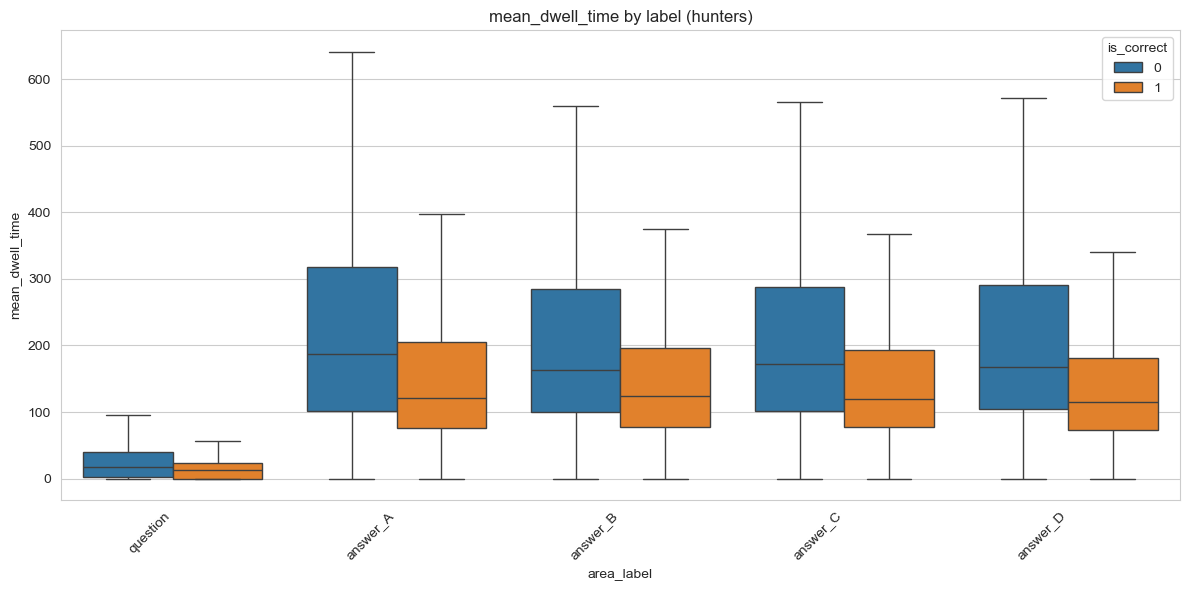

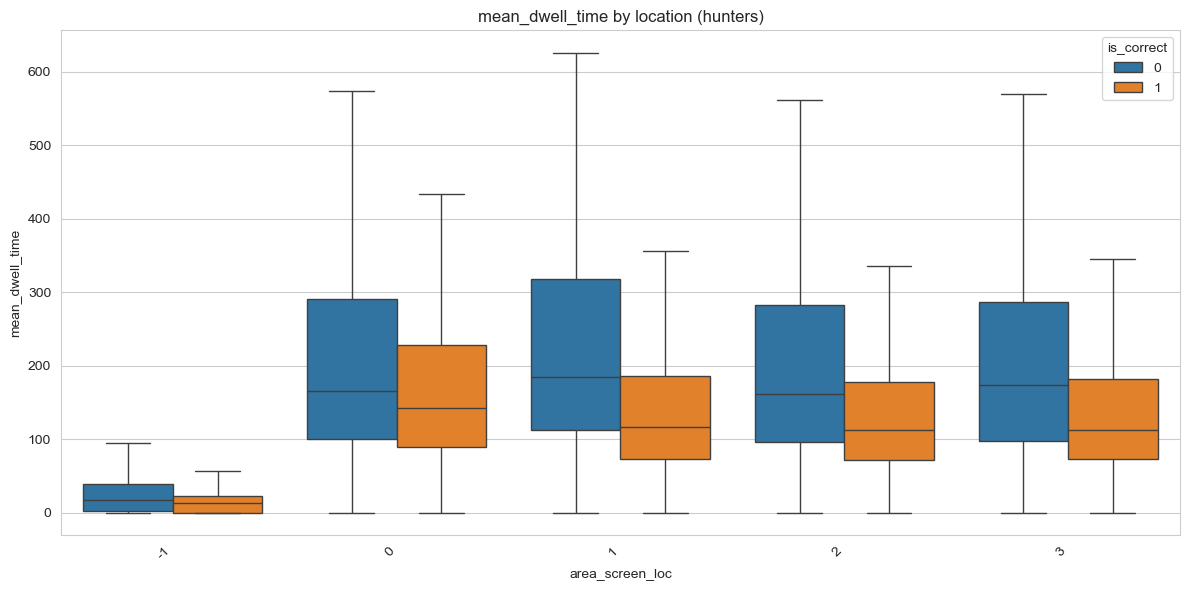

GATHERERS BOXPLOTS:


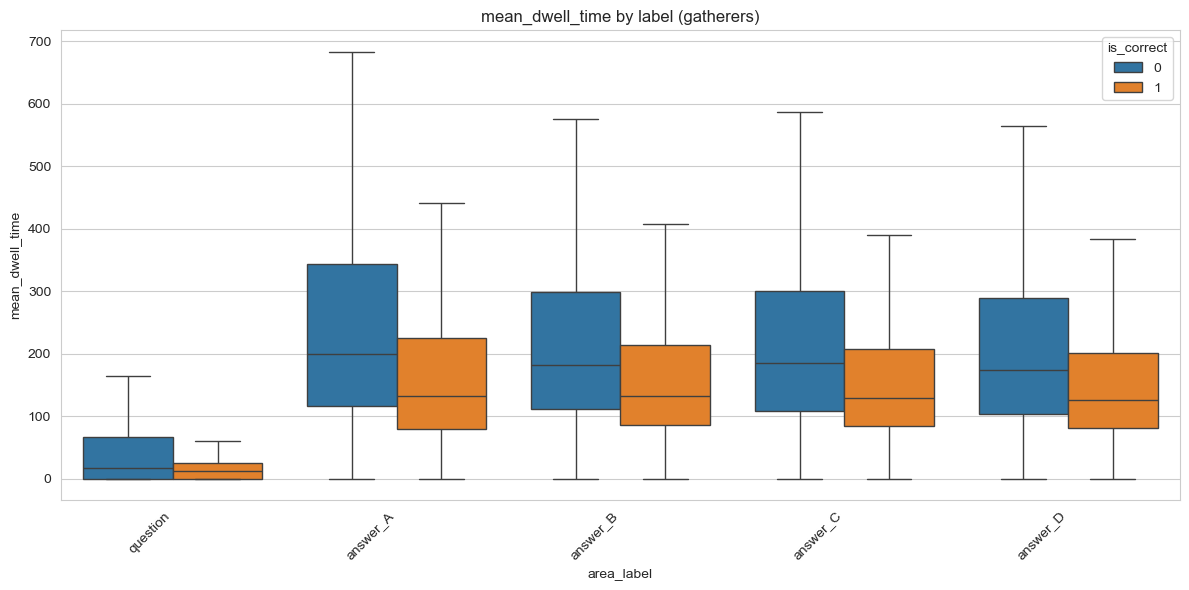

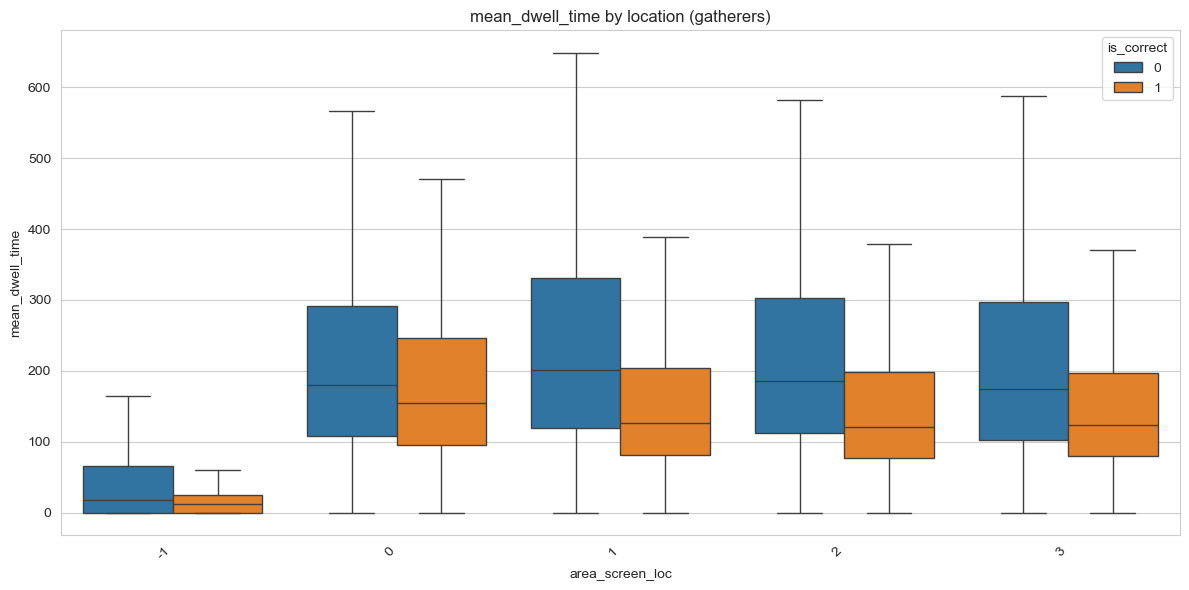

HUNTERS TESTS:
  area_label  coef_correct  p_value_correct  median_correct  median_incorrect  \
4   answer_D    -89.553334     1.045828e-68      115.166667        167.291667   
1   answer_A    -84.436466     3.846263e-52      120.000000        186.681818   
3   answer_C    -70.011708     7.631970e-47      119.333333        171.658333   
0   question    -19.733634     8.406272e-44       13.230769         16.788889   
2   answer_B    -73.526696     3.274232e-43      124.666667        162.787879   

   mean_correct  mean_incorrect  
4    150.898144      240.918359  
1    167.866071      254.786201  
3    158.269254      230.245205  
0     21.678576       42.283031  
2    162.896510      238.537596  
   area_screen_loc  coef_correct  p_value_correct  median_correct  \
3                1   -110.721377    3.820935e-100      116.000000   
1                3    -82.764448     5.834664e-64      111.714286   
4                2    -80.816376     7.166803e-55      112.384615   
0               -1

In [27]:
warnings.filterwarnings("ignore", category=UserWarning, module="statsmodels")
warnings.filterwarnings("ignore", category=ConvergenceWarning, module="statsmodels")

metric_analysis('mean_dwell_time')
# metric_analysis('mean_fixations_count')
# metric_analysis('mean_first_fixation_duration')
# metric_analysis('skip_rate')
# metric_analysis('area_dwell_proportion')

In [28]:
def analyze_group_differences(dataframe, label_column, stat_column, correct_column='is_correct'):
    results = []

    for is_correct_value in dataframe[correct_column].unique():
        subset_df = dataframe[dataframe[correct_column] == is_correct_value]
        categories = subset_df[label_column].unique()

        for cat1, cat2 in combinations(categories, 2):
            group1 = subset_df[subset_df[label_column] == cat1][stat_column]
            group2 = subset_df[subset_df[label_column] == cat2][stat_column]

            if len(group1) == 0 or len(group2) == 0:
                continue

            mannwhitney_result = mannwhitneyu(group1, group2, alternative='two-sided')

            results.append({
                'is_correct': is_correct_value,
                'group1': cat1,
                'group2': cat2,
                'U_statistic': mannwhitney_result.statistic,
                'p_value': mannwhitney_result.pvalue,
                'median_group1': group1.median(),
                'median_group2': group2.median(),
                'mean_group1': group1.mean(),
                'mean_group2': group2.mean()
            })

    results_df = pd.DataFrame(results)
    return results_df.sort_values(['is_correct', 'p_value'])

In [29]:
analyze_group_differences(df_with_features_h, label_column='area_label', stat_column='mean_dwell_time')
analyze_group_differences(df_with_features_h, label_column='area_screen_loc', stat_column='mean_dwell_time')
#
# analyze_group_differences(df_with_features_h, label_column='area_label', stat_column='mean_fixations_count')
# analyze_group_differences(df_with_features_h, label_column='area_screen_loc', stat_column='mean_fixations_count')
#
# analyze_group_differences(df_with_features_h, label_column='area_label', stat_column='mean_first_fixation_duration')
# analyze_group_differences(df_with_features_h, label_column='area_screen_loc', stat_column='mean_first_fixation_duration')
#
# analyze_group_differences(df_with_features_h, label_column='area_label', stat_column='skip_rate')
# analyze_group_differences(df_with_features_h, label_column='area_screen_loc', stat_column='skip_rate')
#
# analyze_group_differences(df_with_features_h, label_column='area_label', stat_column='area_dwell_proportion')
# analyze_group_differences(df_with_features_h, label_column='area_screen_loc', stat_column='area_dwell_proportion')

,is_correct,group1,group2,U_statistic,p_value,median_group1,median_group2,mean_group1,mean_group2
10,0,-1,0,1.042962e+07,0.000000e+00,14.700000,155.428571,39.902299,210.520827
11,0,-1,3,1.072704e+07,0.000000e+00,14.700000,155.888889,39.902299,208.568692
12,0,-1,1,8.911236e+06,0.000000e+00,14.700000,171.444444,39.902299,228.744840
13,0,-1,2,1.169257e+07,0.000000e+00,14.700000,151.941176,39.902299,204.433810
19,0,1,2,4.809668e+07,1.809319e-34,171.444444,151.941176,228.744840,204.433810
17,0,3,1,3.685877e+07,1.051509e-21,155.888889,171.444444,208.568692,228.744840
15,0,0,1,3.891820e+07,1.487055e-14,155.428571,171.444444,210.520827,228.744840
16,0,0,2,4.551382e+07,2.467547e-06,155.428571,151.941176,210.520827,204.433810
18,0,3,2,4.305506e+07,1.993089e-02,155.888889,151.941176,208.568692,204.433810
14,0,0,3,4.111929e+07,2.638866e-02,155.428571,155.888889,210.520827,208.568692


### Matrix Plots

In [30]:
def matrix_plot(df, stat, correct = 1):
    df = df[['TRIAL_INDEX', 'participant_id', 'area_label', 'area_screen_loc', stat]].drop_duplicates().copy()
    matrix = pd.pivot_table(
        data=df,
        index='area_label',
        columns='area_screen_loc',
        values=stat,
        aggfunc='mean'
    )

    ax = sns.heatmap(
    matrix,
    annot=True,
    cmap='Blues',
    fmt=".2f",
    cbar_kws={'label': f'{stat}'}
    )
    if correct == 1:
        plt.title(f"{stat} of correct answers")
    else:
        plt.title(f"{stat} of incorrect answers")
    plt.xlabel('area_screen_loc')
    plt.ylabel("area_label")
    plt.tight_layout()
    plt.show()


In [31]:
def matrix_plot_ABCD(df, stat, selected = 'A'):
    df = df[['TRIAL_INDEX', 'participant_id', 'area_label', 'area_screen_loc', stat]].drop_duplicates().copy()
    matrix = pd.pivot_table(
        data=df,
        index='area_label',
        columns='area_screen_loc',
        values=stat,
        aggfunc='mean'
    )

    ax = sns.heatmap(
    matrix,
    annot=True,
    cmap='Blues',
    fmt=".2f",
    cbar_kws={'label': f'{stat}'}
    )

    plt.title(f"{stat} of those who chose {selected} ")
    plt.xlabel('area_screen_loc')
    plt.ylabel("area_label")
    plt.tight_layout()
    plt.show()

In [32]:
def label_vs_loc_mat(metric):
    print("HUNTERS")
    matrix_plot_ABCD(df_with_features_h[df_with_features_h['selected_answer_label'] == 'A'], metric, selected='A')
    matrix_plot_ABCD(df_with_features_h[df_with_features_h['selected_answer_label'] == 'B'], metric, selected='B')
    matrix_plot_ABCD(df_with_features_h[df_with_features_h['selected_answer_label'] == 'C'], metric, selected='C')
    matrix_plot_ABCD(df_with_features_h[df_with_features_h['selected_answer_label'] == 'D'], metric, selected='D')
    # matrix_plot(df_with_features_h[df_with_features_h['is_correct'] == 0],metric, correct = 0)
    # matrix_plot(df_with_features_h[df_with_features_h['is_correct'] == 1],metric, correct = 1)

    print("GATHERERS")
    matrix_plot_ABCD(df_with_features_g[df_with_features_g['selected_answer_label'] == 'A'], metric, selected='A')
    matrix_plot_ABCD(df_with_features_g[df_with_features_g['selected_answer_label'] == 'B'], metric, selected='B')
    matrix_plot_ABCD(df_with_features_g[df_with_features_g['selected_answer_label'] == 'C'], metric, selected='C')
    matrix_plot_ABCD(df_with_features_g[df_with_features_g['selected_answer_label'] == 'D'], metric, selected='D')
    # matrix_plot(df_with_features_g[df_with_features_g['is_correct'] == 0], metric, correct = 0)
    # matrix_plot(df_with_features_g[df_with_features_g['is_correct'] == 1], metric, correct = 1)

HUNTERS


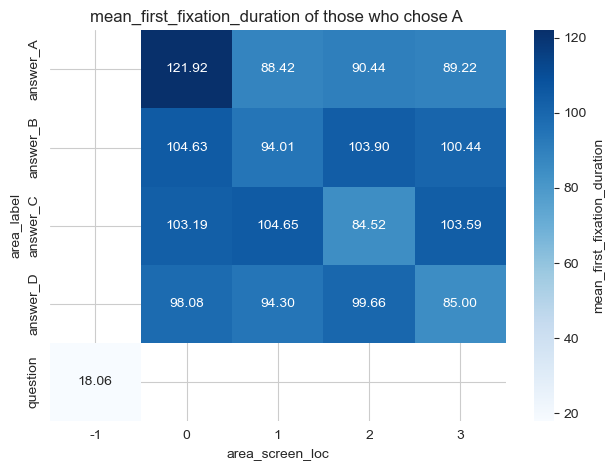

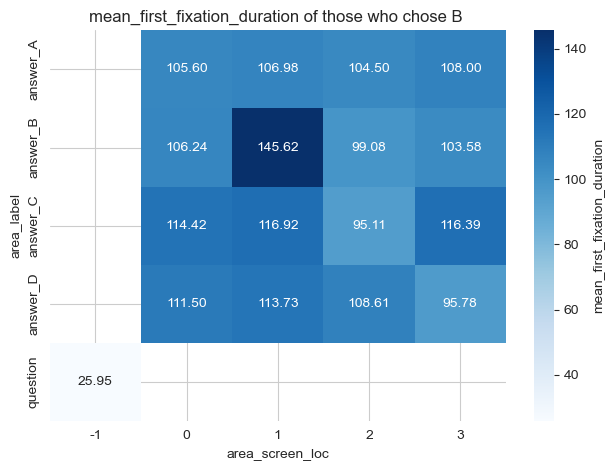

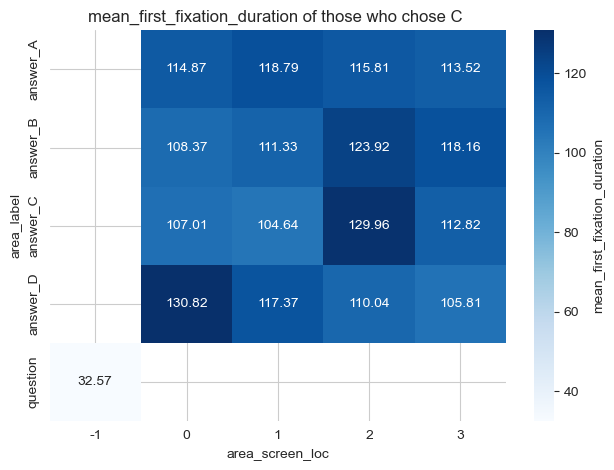

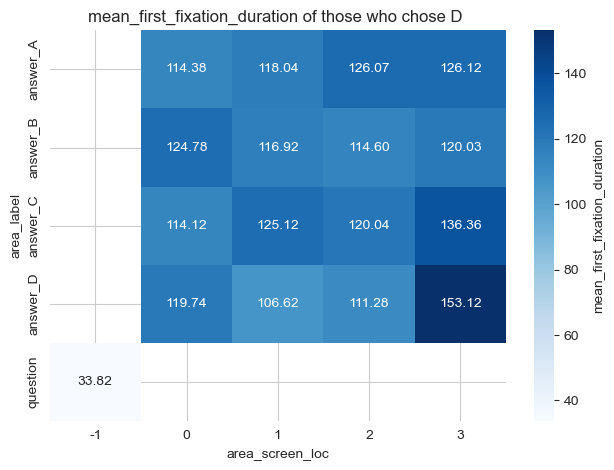

GATHERERS


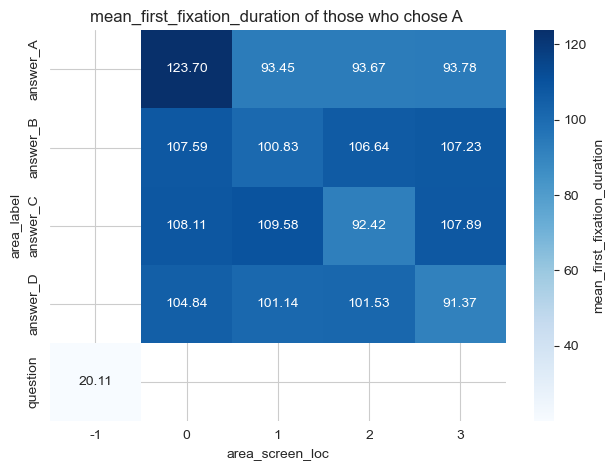

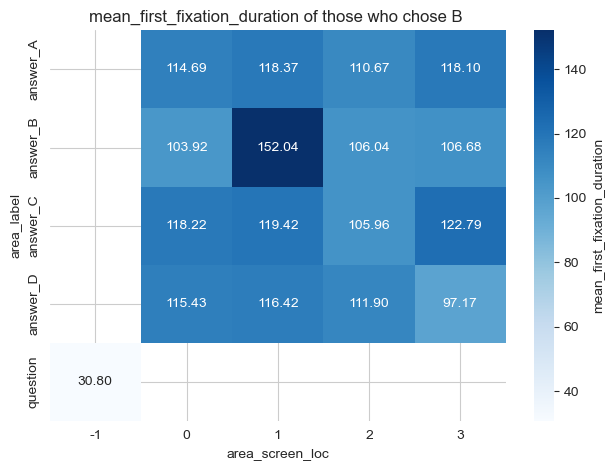

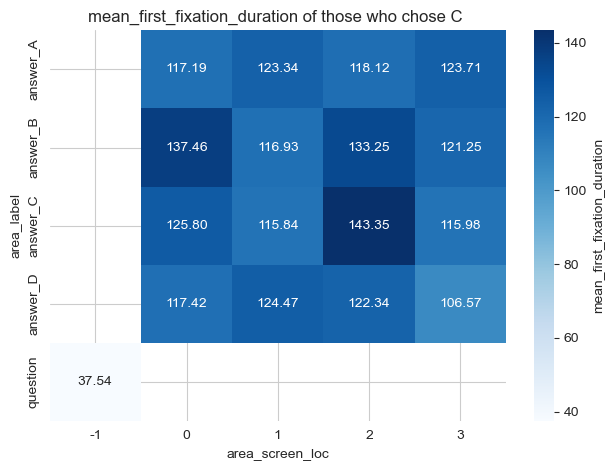

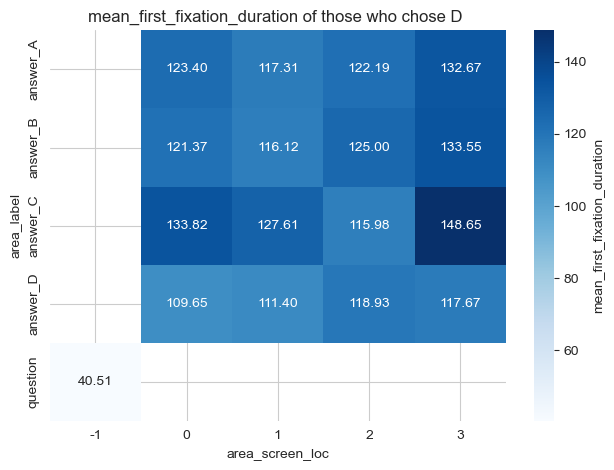

In [33]:
# label_vs_loc_mat('mean_dwell_time')
# label_vs_loc_mat('mean_fixations_count')
label_vs_loc_mat('mean_first_fixation_duration')
# label_vs_loc_mat('skip_rate')
# label_vs_loc_mat('area_dwell_proportion')



In [34]:
print(df_with_features_h['selected_answer_label'].value_counts())
print(df_with_features_g['selected_answer_label'].value_counts())


selected_answer_label
A    331307
B     27970
C     14749
D      6324
Name: count, dtype: int64
selected_answer_label
A    312206
B     36502
C     21429
D     10141
Name: count, dtype: int64


### Selected vs not selected

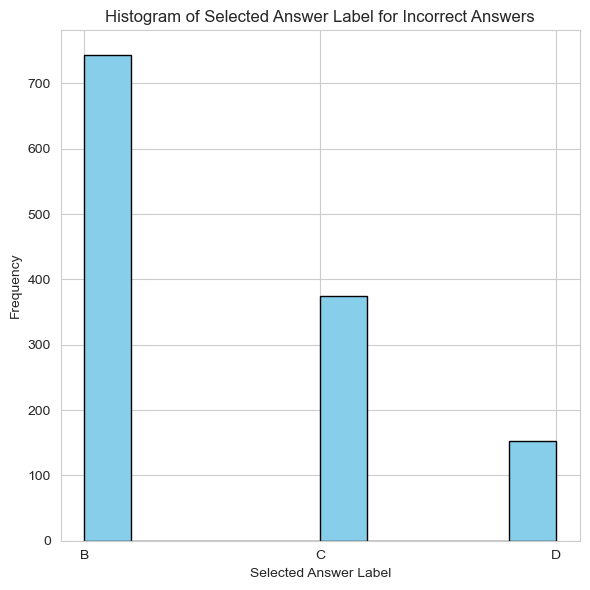

In [35]:
df = df_with_features_h[['TRIAL_INDEX', 'participant_id', 'is_correct', 'selected_answer_label']].drop_duplicates().copy()
incorrect_answers = df[df['is_correct'] == 0]

plt.figure(figsize=(6, 6))
plt.hist(incorrect_answers['selected_answer_label'], bins=10, color='skyblue', edgecolor='black')
plt.title('Histogram of Selected Answer Label for Incorrect Answers')
plt.xlabel('Selected Answer Label')
plt.ylabel('Frequency')
plt.grid(True)
plt.tight_layout()
plt.show()

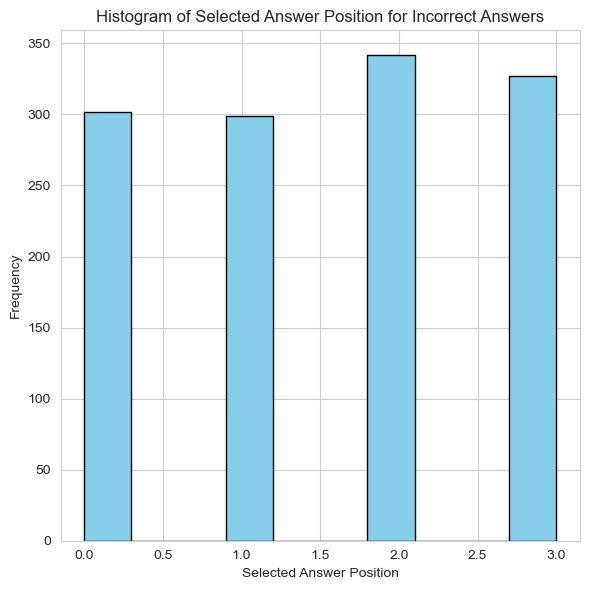

In [36]:
df = df_with_features_h[['TRIAL_INDEX', 'participant_id', 'is_correct', 'selected_answer_position']].drop_duplicates().copy()
incorrect_answers = df[df['is_correct'] == 0]

plt.figure(figsize=(6, 6))
plt.hist(incorrect_answers['selected_answer_position'], bins=10, color='skyblue', edgecolor='black')
plt.title('Histogram of Selected Answer Position for Incorrect Answers')
plt.xlabel('Selected Answer Position')
plt.ylabel('Frequency')
plt.grid(True)
plt.tight_layout()
plt.show()

C:\Users\deeth\AppData\Local\Temp\ipykernel_30580\4182384254.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['is_selected_area'] = df_filtered['area_label'] == df_filtered['selected_area']


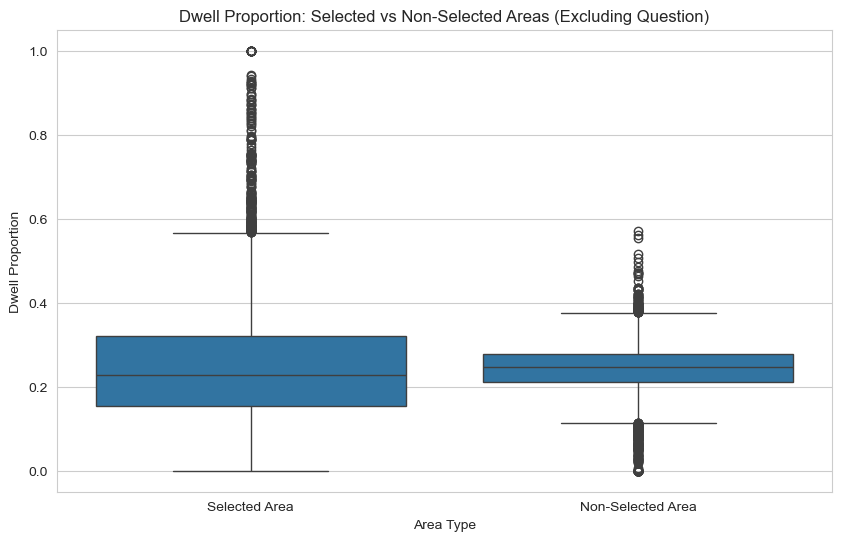

In [37]:
df_filtered = df_with_features_h[df_with_features_h['area_label'].isin(['answer_A', 'answer_B', 'answer_C', 'answer_D'])]
df_filtered['is_selected_area'] = df_filtered['area_label'] == df_filtered['selected_area']

selected_vs_nonselected = df_filtered.groupby(['TRIAL_INDEX', 'participant_id', 'is_selected_area'])['area_dwell_proportion'].mean().reset_index()
selected_vs_nonselected['area_type'] = selected_vs_nonselected['is_selected_area'].replace({True: 'Selected Area', False: 'Non-Selected Area'})

plt.figure(figsize=(10, 6))
sns.boxplot(
    data=selected_vs_nonselected,
    x='area_type',
    y='area_dwell_proportion',
    order=['Selected Area', 'Non-Selected Area']
)
plt.title('Dwell Proportion: Selected vs Non-Selected Areas (Excluding Question)')
plt.xlabel('Area Type')
plt.ylabel('Dwell Proportion')
plt.show()


C:\Users\deeth\AppData\Local\Temp\ipykernel_30580\2839663135.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['is_selected_area'] = df_filtered['area_label'] == df_filtered['selected_area']


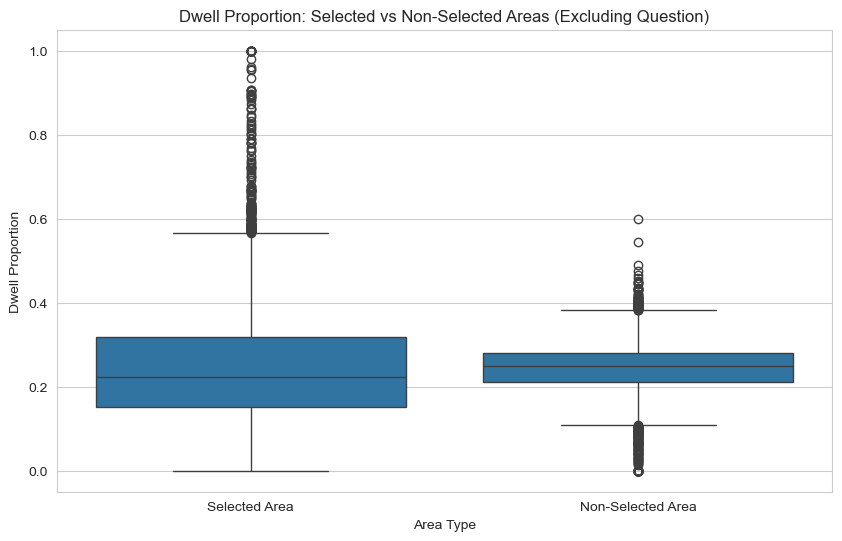

In [38]:
df_filtered = df_with_features_g[df_with_features_g['area_label'].isin(['answer_A', 'answer_B', 'answer_C', 'answer_D'])]
df_filtered['is_selected_area'] = df_filtered['area_label'] == df_filtered['selected_area']

selected_vs_nonselected = df_filtered.groupby(['TRIAL_INDEX', 'participant_id', 'is_selected_area'])['area_dwell_proportion'].mean().reset_index()
selected_vs_nonselected['area_type'] = selected_vs_nonselected['is_selected_area'].replace({True: 'Selected Area', False: 'Non-Selected Area'})

plt.figure(figsize=(10, 6))
sns.boxplot(
    data=selected_vs_nonselected,
    x='area_type',
    y='area_dwell_proportion',
    order=['Selected Area', 'Non-Selected Area']
)
plt.title('Dwell Proportion: Selected vs Non-Selected Areas (Excluding Question)')
plt.xlabel('Area Type')
plt.ylabel('Dwell Proportion')
plt.show()


### Fixation Sequence Visualizations

In [39]:
df_with_features_h['fix_by_label'] = df_with_features_h['fix_by_label'].apply(lambda x: tuple(x) if isinstance(x, list) else x)
df_with_features_g['fix_by_label'] = df_with_features_g['fix_by_label'].apply(lambda x: tuple(x) if isinstance(x, list) else x)
df_with_features_h['fix_by_loc'] = df_with_features_h['fix_by_loc'].apply(lambda x: tuple(x) if isinstance(x, list) else x)
df_with_features_g['fix_by_loc'] = df_with_features_g['fix_by_loc'].apply(lambda x: tuple(x) if isinstance(x, list) else x)

data_rows_h = df_with_features_h[['TRIAL_INDEX', 'participant_id', 'fix_by_label', 'fix_by_loc','selected_answer_label', 'correct_answer_position']].drop_duplicates().reset_index()
data_rows_g = df_with_features_g[['TRIAL_INDEX', 'participant_id', 'fix_by_label', 'fix_by_loc','selected_answer_label', 'correct_answer_position']].drop_duplicates().reset_index()



In [40]:
data_rows_h

,index,TRIAL_INDEX,participant_id,fix_by_label,fix_by_loc,selected_answer_label,correct_answer_position
0,0,4,l42_2070,"(question, question, question, question, quest...","(-1, -1, -1, -1, -1, 1, 3, 3, 3, 3, 1, 1, 1, 3...",A,3
1,33,5,l42_2070,"(out_of_bounds, question, question, answer_A, ...","(out_of_bounds, -1, -1, 1, 1, -1, 1, -1, 1, -1...",A,2
2,73,6,l42_2070,"(question, answer_A, answer_A, answer_A, answe...","(-1, 1, 1, 1, 1, 1, 1, 3, 3, 3, 2, 3, 3, 2, 3,...",A,2
3,114,7,l42_2070,"(question, question, question, question, answe...","(-1, -1, -1, -1, 3, 1, 2, 3, 2, 1, out_of_boun...",A,2
4,149,8,l42_2070,"(question, question, question, question, answe...","(-1, -1, -1, -1, 1, 3, 2, out_of_bounds, 2, 3,...",A,2
...,...,...,...,...,...,...,...
9714,380126,55,l10_39,"(question, out_of_bounds, question, question, ...","(-1, out_of_bounds, -1, -1, -1, 3, -1, -1, -1,...",A,3
9715,380170,56,l10_39,"(question, out_of_bounds, question, question, ...","(-1, out_of_bounds, -1, -1, 1, out_of_bounds, ...",A,1
9716,380224,57,l10_39,"(question, question, question, question, answe...","(-1, -1, -1, -1, 1, -1, -1, 1, out_of_bounds, ...",C,1
9717,380267,58,l10_39,"(answer_A, out_of_bounds, answer_A, answer_A, ...","(1, out_of_bounds, 1, 1, out_of_bounds, 3, 3, ...",A,2


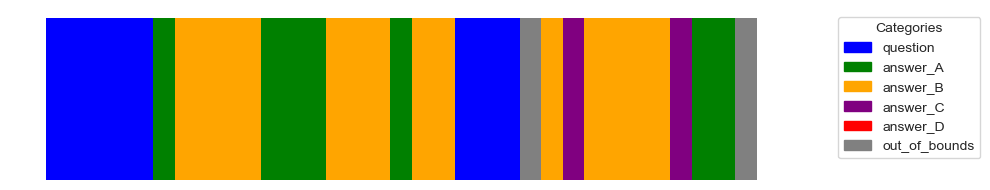

In [41]:
data_row = df_with_features_h.iloc[0]['fix_by_label']

categories = {
    "question": "blue",
    "answer_A": "green",
    "answer_B": "orange",
    "answer_C": "purple",
    "answer_D": "red",
    "out_of_bounds": "gray"
}
colors = [categories[value] for value in data_row]

plt.figure(figsize=(10, 2))
plt.bar(range(len(data_row)), [1] * len(data_row), color=colors, width=1.0, edgecolor='none')
plt.axis('off')

legend_handles = [mpatches.Patch(color=color, label=label) for label, color in categories.items()]
plt.legend(handles=legend_handles, bbox_to_anchor=(1.05, 1), loc='upper left', title="Categories")

plt.tight_layout()
plt.show()

In [42]:
categories_label = {
    "question": "#74a9cf",
    "answer_A": "#238b45",
    "answer_B": "#74c476",
    "answer_C": "#bae4b3",
    "answer_D": "#edf8e9",

    "A": "green",
    "B": "gold",
    "C": "darkorange",
    "D": "red",

    "out_of_bounds": "white"
}

categories_loc = {
    -1: "#74a9cf",
    0: "#ffffb2",
    1: "#fecc5c",
    2: "#fd8d3c",
    3: "#e31a1c",

    "A": "green",
    "B": "gold",
    "C": "darkorange",
    "D": "red",

    "out_of_bounds": "white"
}

legend_mapping_label = {
    "question": "Question",
    "answer_A": "Answer A",
    "answer_B": "Answer B",
    "answer_C": "Answer C",
    "answer_D": "Answer D",
    "out_of_bounds": "Unclear",

    "A": None,
    "B": None,
    "C": None,
    "D": None,
}

legend_mapping_loc = {
    "out_of_bounds": "Unclear",
    -1: "Question",
    0: "First A on screen",
    1: "Second A on screen",
    2: "Third A on screen",
    3: "Fourth A on screen",

    "A": None,
    "B": None,
    "C": None,
    "D": None,
}


In [43]:
def visualize_stacked_rows_with_two_labels(data_rows, categories, selected_answer_labels, additional_labels, num_rows=100, start_index=0, legend_mapping=None):
    selected_rows = data_rows[start_index:start_index + num_rows]
    selected_labels = selected_answer_labels[start_index:start_index + num_rows]
    additional_labels = additional_labels[start_index:start_index + num_rows]


    max_length = max(len(row) for row in selected_rows) + 2  # +2 to account for the labels

    color_data = []
    for row in selected_rows:
        color_row = [categories.get(value, "gray") for value in row] + ["white"] * (max_length - len(row))
        color_data.append(color_row)

    plt.figure(figsize=(15, num_rows * 0.3))
    for i, (color_row, label, additional_label) in enumerate(zip(color_data, selected_labels, additional_labels)):
        plt.bar(range(max_length), [1] * max_length, color=color_row, width=1.0, edgecolor='none', bottom=i)
        plt.text(-3.5, i + 0.5, str(additional_label), va='center', ha='right', fontsize=10, color=categories.get(additional_label, "black"))
        plt.text(-1.5, i + 0.5, str(label), va='center', ha='right', fontsize=10, color=categories.get(label, "black"))

    plt.axis('off')

    if legend_mapping:
        legend_handles = [
            mpatches.Patch(color=categories.get(original_label, "gray"), label=new_label)
            for original_label, new_label in legend_mapping.items()
            if new_label is not None
        ]
    else:
        legend_handles = [
            mpatches.Patch(color=color, label=str(label)) for label, color in categories.items()
        ]

    plt.legend(handles=legend_handles, bbox_to_anchor=(1.05, 1), loc='upper left', title="Categories")

    plt.tight_layout()
    plt.show()

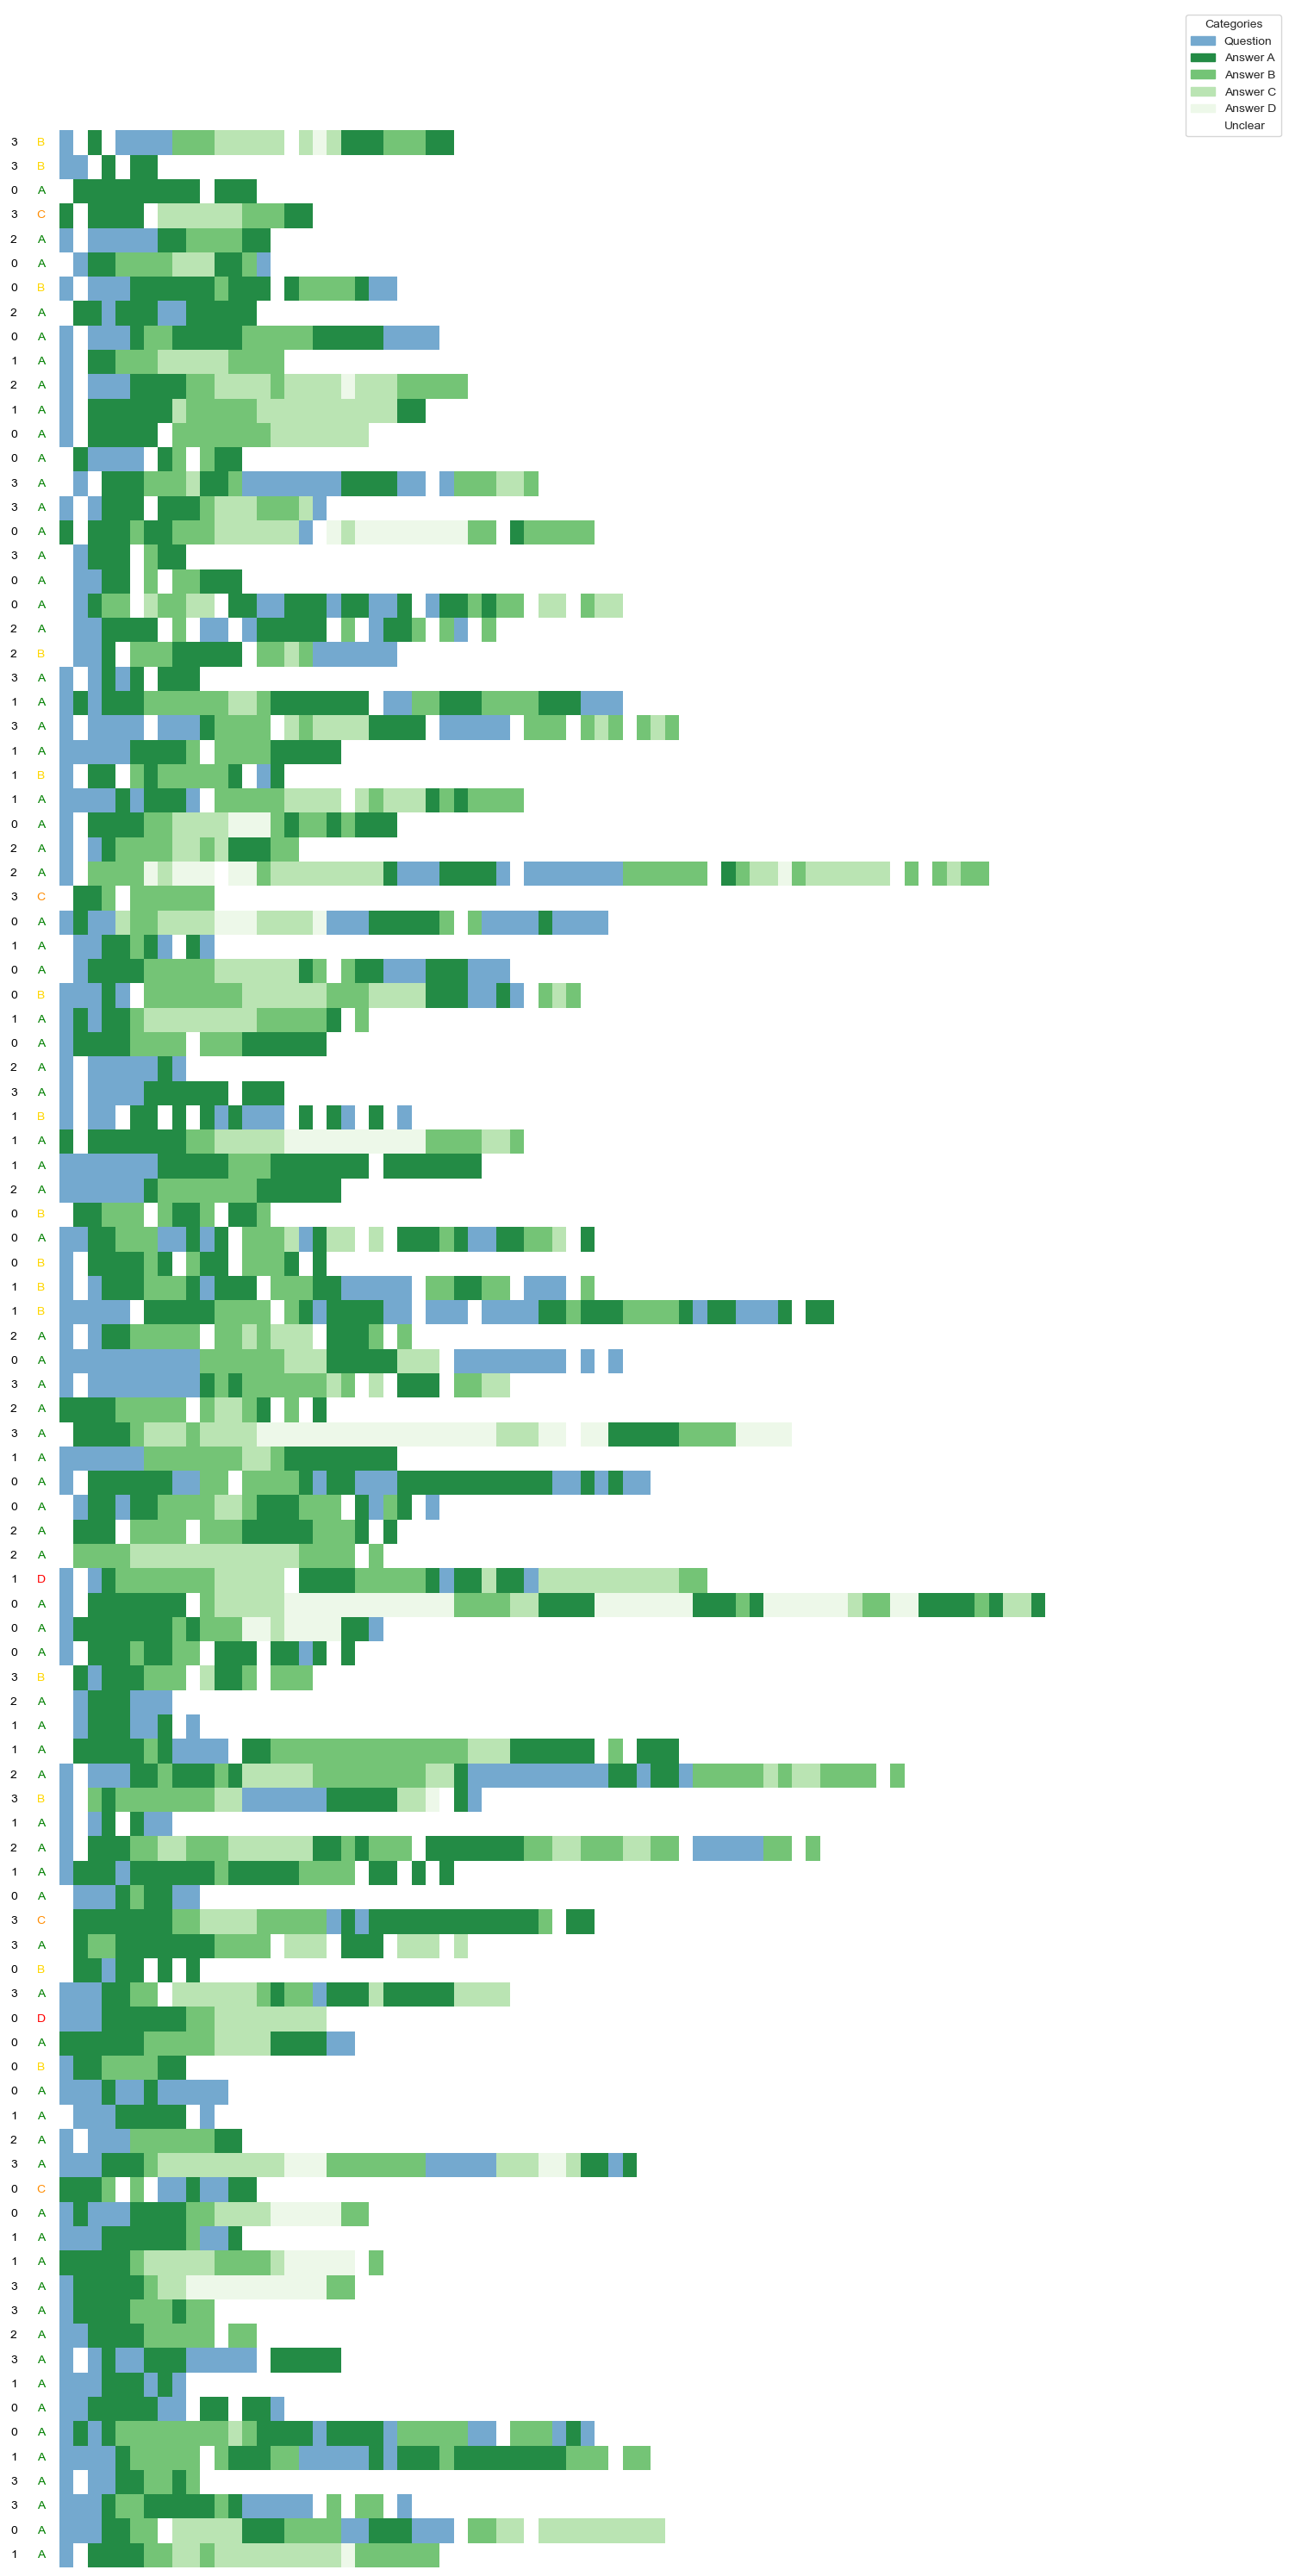

In [44]:
visualize_stacked_rows_with_two_labels(
    data_rows=data_rows_h['fix_by_label'],
    categories=categories_label,
    selected_answer_labels=data_rows_h['selected_answer_label'],
    additional_labels=data_rows_h['correct_answer_position'],
    num_rows=100,
    start_index=300,
    legend_mapping=legend_mapping_label
)

In [45]:
corr_in_zero = data_rows_h[data_rows_h['selected_answer_label'] == 'C']

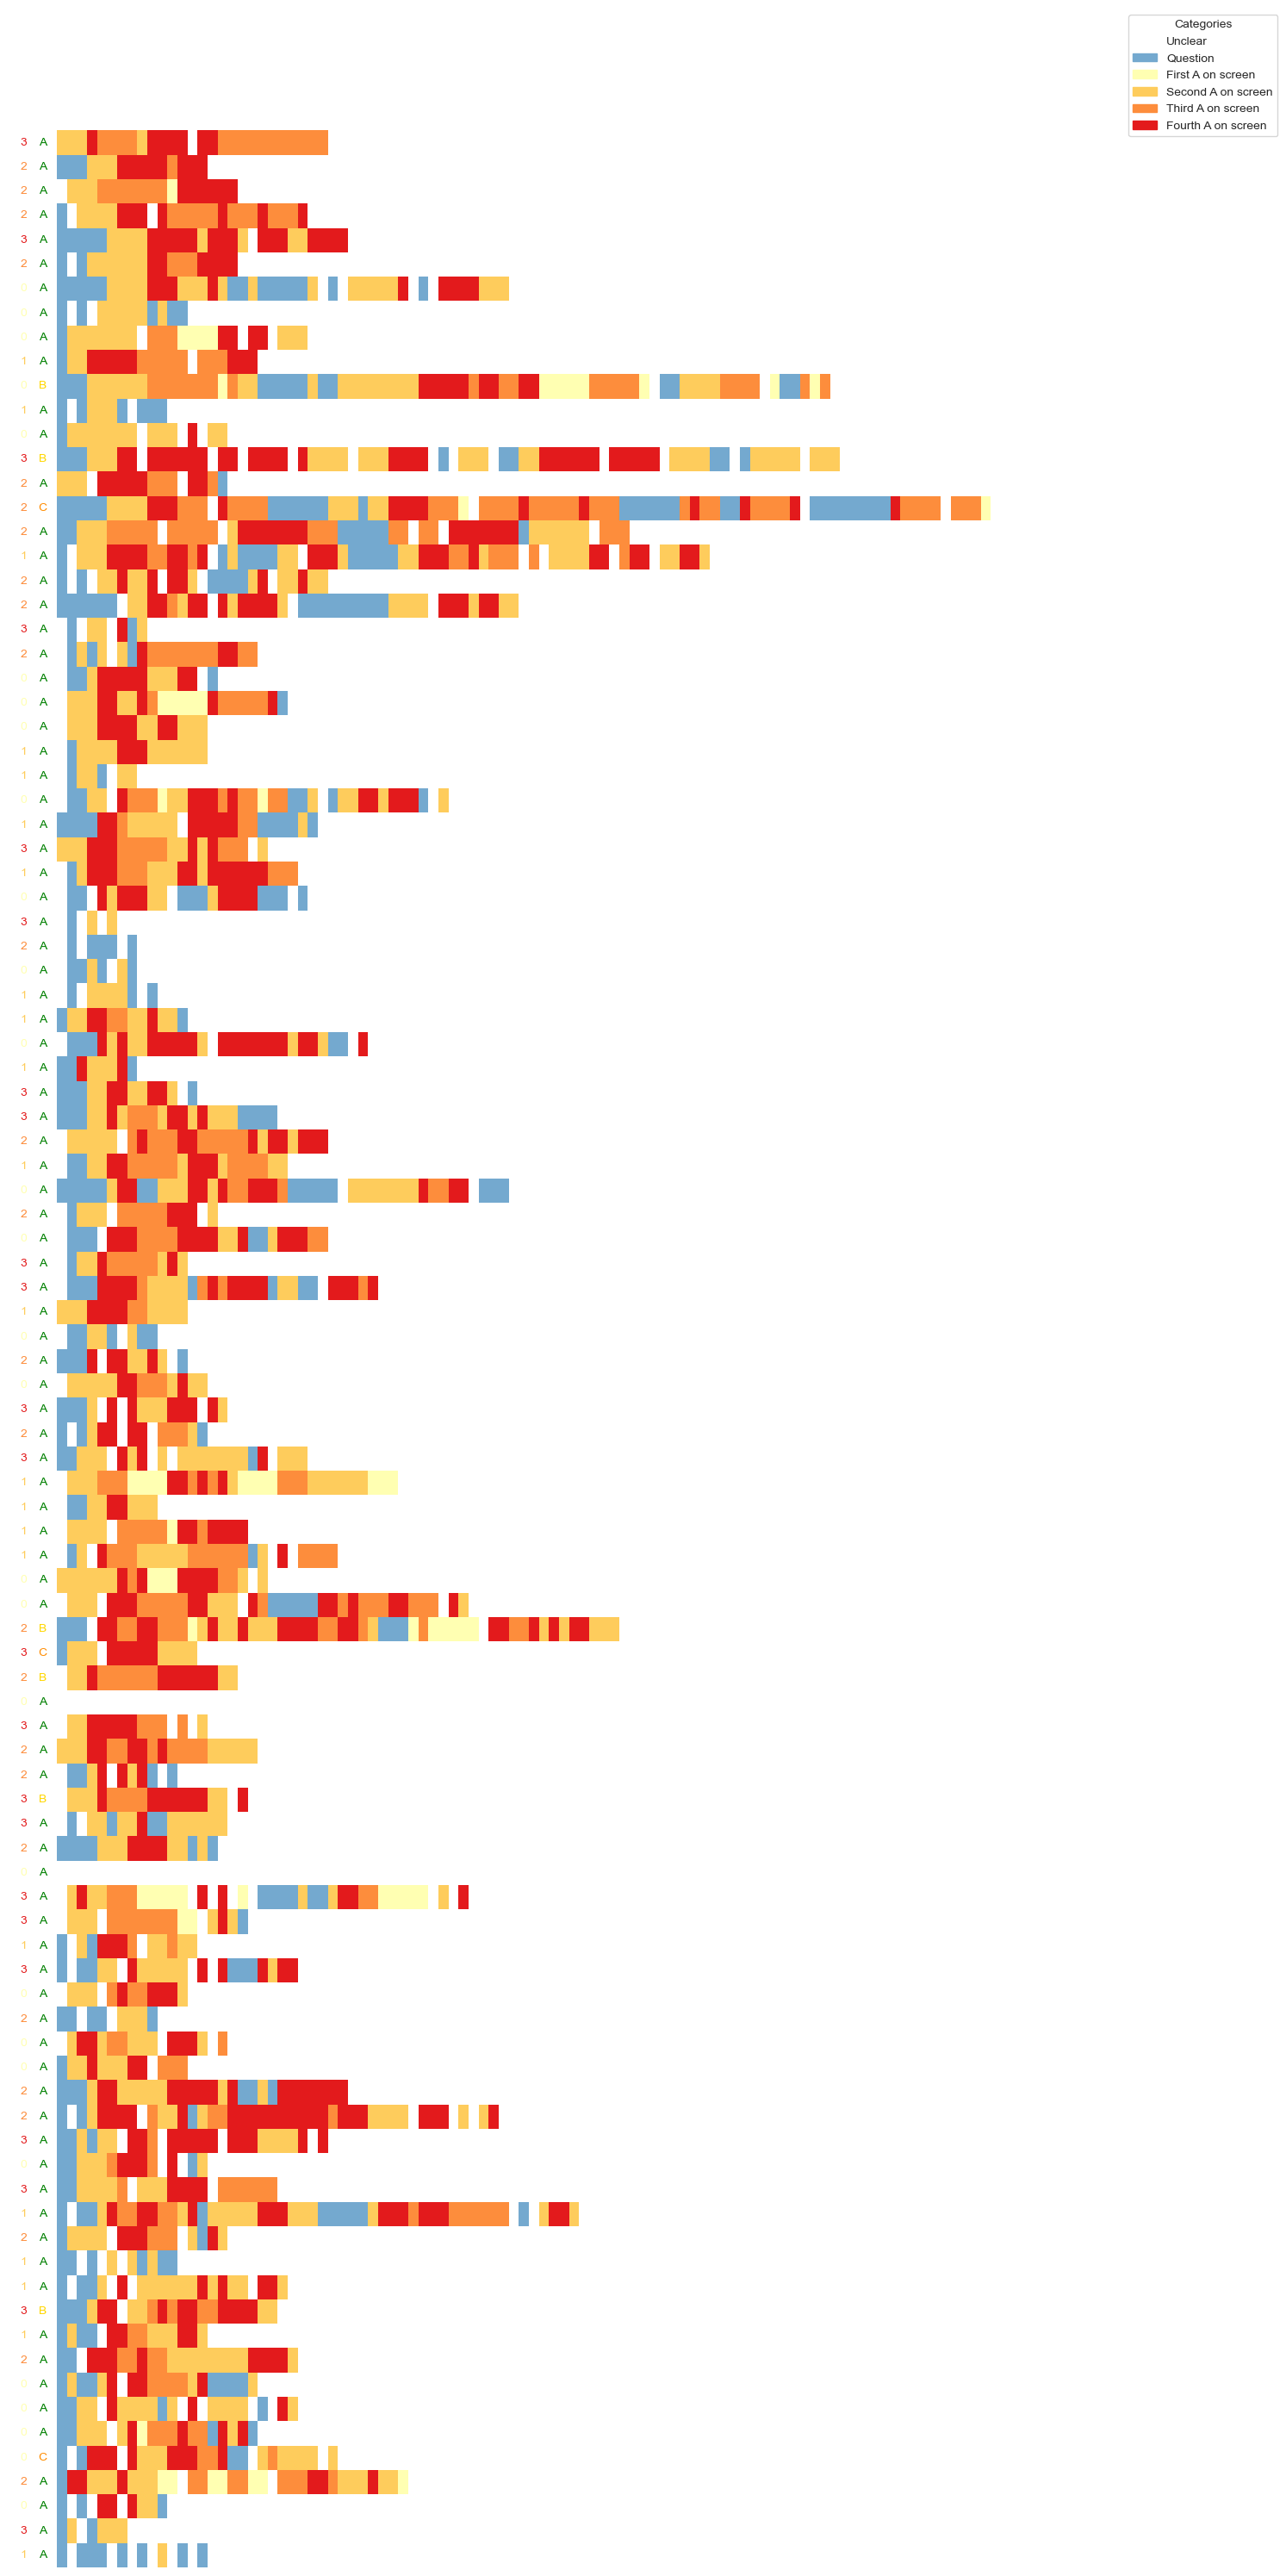

In [46]:
visualize_stacked_rows_with_two_labels(
    data_rows=data_rows_h['fix_by_loc'],
    categories=categories_loc,
    selected_answer_labels=data_rows_h['selected_answer_label'],
    additional_labels=data_rows_h['correct_answer_position'],
    num_rows=100,
    start_index=1000,
    legend_mapping=legend_mapping_loc
)
#print by text + q/ by participant

# Some sanity checks

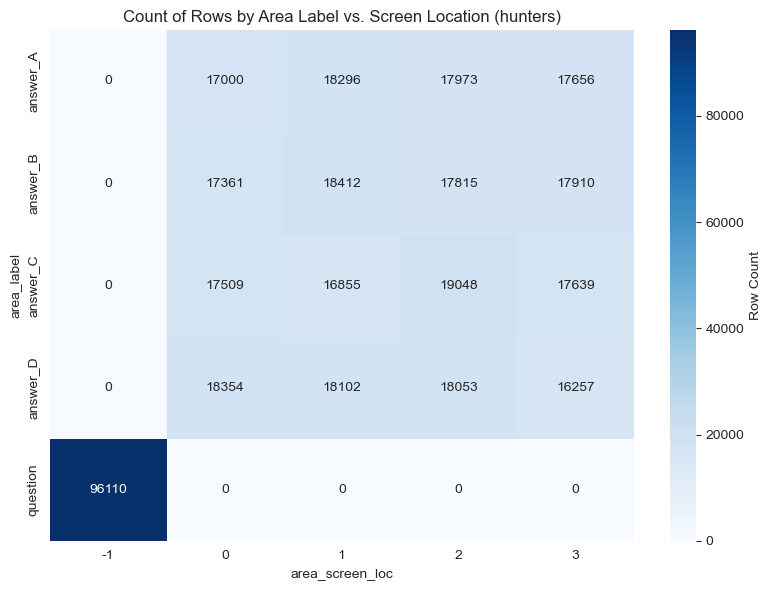

In [47]:
count_matrix = (df_with_features_h
    .groupby(['area_label', 'area_screen_loc'])
    .size()
    .unstack(fill_value=0)
)

plt.figure(figsize=(8, 6))
sns.heatmap(
    count_matrix,
    annot=True,
    fmt="d",
    cmap="Blues",
    cbar_kws={'label': 'Row Count'}
)
plt.title("Count of Rows by Area Label vs. Screen Location (hunters)")
plt.xlabel("area_screen_loc")
plt.ylabel("area_label")
plt.tight_layout()
plt.show()

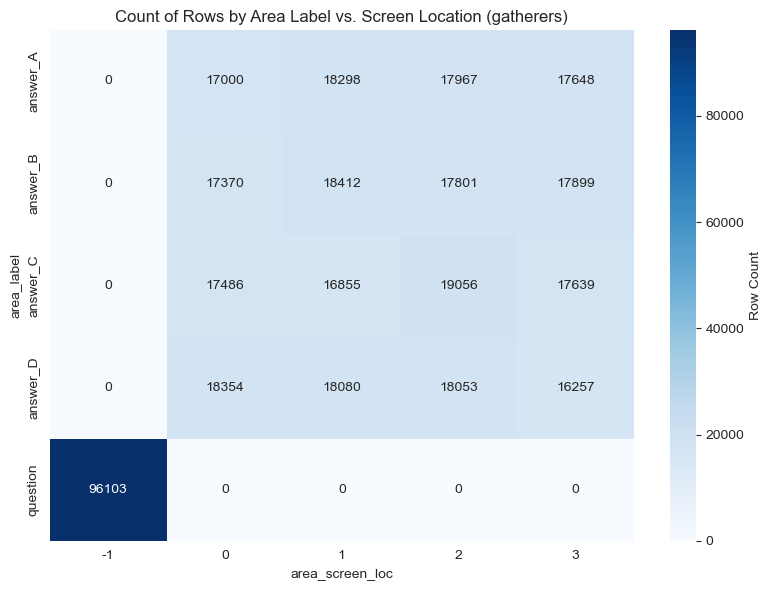

In [48]:
count_matrix = (df_with_features_g
    .groupby(['area_label', 'area_screen_loc'])
    .size()
    .unstack(fill_value=0)
)

plt.figure(figsize=(8, 6))
sns.heatmap(
    count_matrix,
    annot=True,
    fmt="d",
    cmap="Blues",
    cbar_kws={'label': 'Row Count'}
)
plt.title("Count of Rows by Area Label vs. Screen Location (gatherers)")
plt.xlabel("area_screen_loc")
plt.ylabel("area_label")
plt.tight_layout()
plt.show()

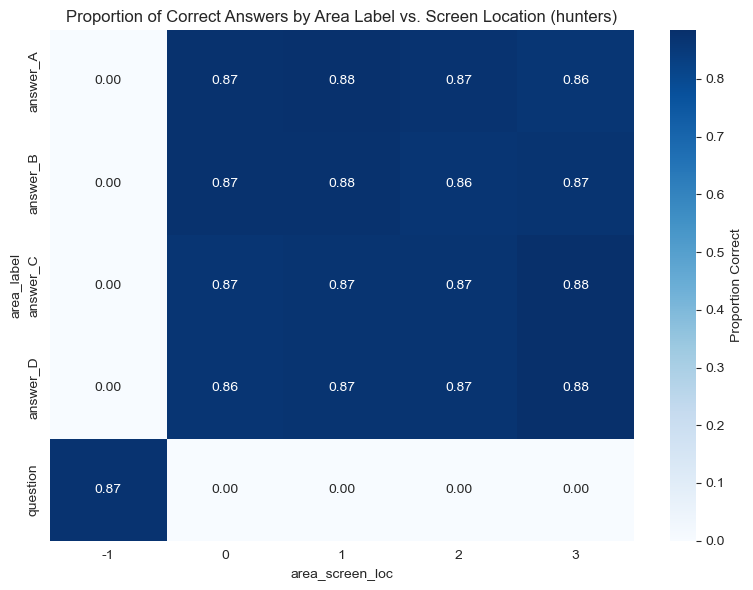

In [49]:
prop_matrix = (
    df_with_features_h
    .groupby(['area_label', 'area_screen_loc'])['is_correct']
    .mean()
    .unstack(fill_value=0)
)

plt.figure(figsize=(8, 6))
sns.heatmap(
    prop_matrix,
    annot=True,
    fmt=".2f",
    cmap="Blues",
    cbar_kws={'label': 'Proportion Correct'}
)
plt.title("Proportion of Correct Answers by Area Label vs. Screen Location (hunters)")
plt.xlabel("area_screen_loc")
plt.ylabel("area_label")
plt.tight_layout()
plt.show()

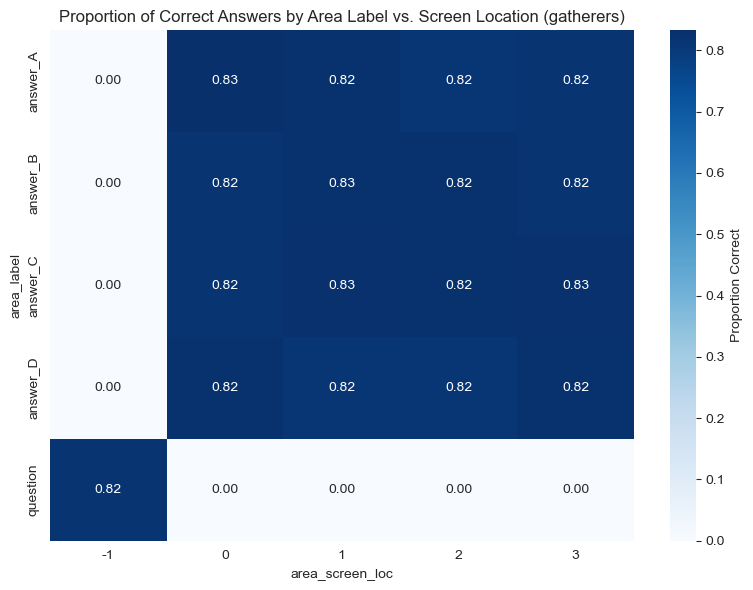

In [50]:
prop_matrix = (
    df_with_features_g
    .groupby(['area_label', 'area_screen_loc'])['is_correct']
    .mean()
    .unstack(fill_value=0)
)

plt.figure(figsize=(8, 6))
sns.heatmap(
    prop_matrix,
    annot=True,
    fmt=".2f",
    cmap="Blues",
    cbar_kws={'label': 'Proportion Correct'}
)
plt.title("Proportion of Correct Answers by Area Label vs. Screen Location (gatherers)")
plt.xlabel("area_screen_loc")
plt.ylabel("area_label")
plt.tight_layout()
plt.show()

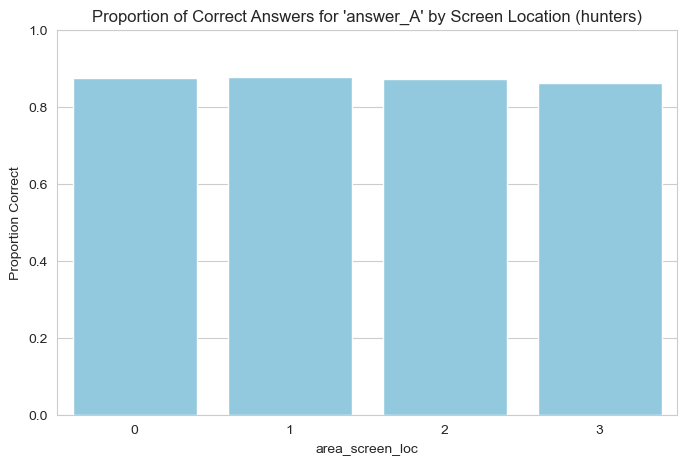

In [51]:
df_answer_A = df_with_features_h[df_with_features_h['area_label'] == 'answer_A']

prop_correct = (
    df_answer_A
    .groupby('area_screen_loc')['is_correct']
    .mean()
    .reset_index(name='prop_correct')
)

plt.figure(figsize=(8, 5))
sns.barplot(data=prop_correct, x='area_screen_loc', y='prop_correct', color='skyblue')
plt.ylim(0, 1)
plt.title("Proportion of Correct Answers for 'answer_A' by Screen Location (hunters)")
plt.xlabel("area_screen_loc")
plt.ylabel("Proportion Correct")
plt.show()

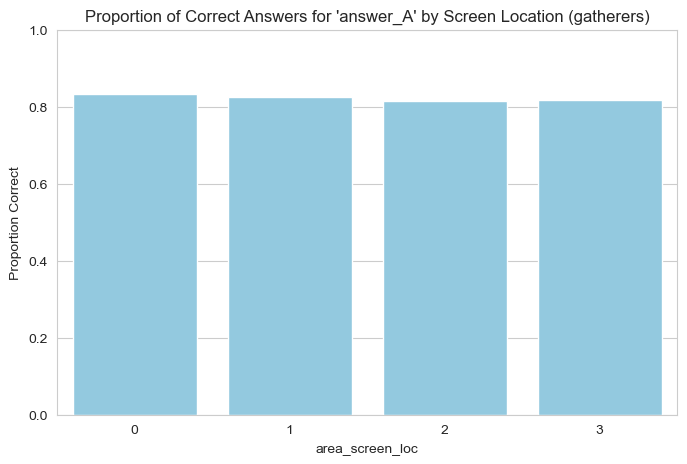

In [52]:
df_answer_A = df_with_features_g[df_with_features_g['area_label'] == 'answer_A']

prop_correct = (
    df_answer_A
    .groupby('area_screen_loc')['is_correct']
    .mean()
    .reset_index(name='prop_correct')
)

plt.figure(figsize=(8, 5))
sns.barplot(data=prop_correct, x='area_screen_loc', y='prop_correct', color='skyblue')
plt.ylim(0, 1)
plt.title("Proportion of Correct Answers for 'answer_A' by Screen Location (gatherers)")
plt.xlabel("area_screen_loc")
plt.ylabel("Proportion Correct")
plt.show()